<a href="https://colab.research.google.com/github/AUT-Student/NLP-HW2/blob/main/NLP_HW2_Q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><b>In the name of God</b></center>

<b>Course</b>: Natural Language Processing
<br>
<b>Description:</b> HomeWork 2 | Question 2
<br>
<b>Developer</b>: Alireza Mazochi (400131075)

# Libraries

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix 
import seaborn as sn

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Bidirectional, TimeDistributed
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras import backend

# Dataset

In [2]:
!gdown 1Px1lQhMgkdeFigxwmqvk1ojJPZpq40u5
!gdown 1WHbpY1Ydqq7yqtQ2YFavR78zsD7nDwbg
!gdown 1pMJQk75R3898sUzFKUMQTPPE_QlllvAY
!gdown 1NMesvM67oiJ6-PpSbtErFanj0JMl_Z50

Downloading...
From: https://drive.google.com/uc?id=1Px1lQhMgkdeFigxwmqvk1ojJPZpq40u5
To: /content/UPC_2016_train.txt
100% 25.4M/25.4M [00:00<00:00, 62.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1WHbpY1Ydqq7yqtQ2YFavR78zsD7nDwbg
To: /content/UPC_2016_val.txt
100% 5.47M/5.47M [00:00<00:00, 34.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1pMJQk75R3898sUzFKUMQTPPE_QlllvAY
To: /content/UPC_2016_test.txt
100% 5.48M/5.48M [00:00<00:00, 67.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1NMesvM67oiJ6-PpSbtErFanj0JMl_Z50
To: /content/vectors.zip
100% 48.2M/48.2M [00:01<00:00, 32.5MB/s]


In [3]:
def read_dataset(filepath):
  file = open(filepath, "r")

  dataset = [[]]

  item_counter = 0
  end_line = False
  for line in file.readlines():
    line_splitted = line.split()
    if len(line_splitted) == 2:  
      token, tag = line_splitted
      
      dataset[-1].append((token, tag))
    else:
      dataset.append([])
      item_counter += 1

  return dataset[:-1]

In [4]:
train_dataset = read_dataset("/content/UPC_2016_train.txt")
valid_dataset = read_dataset("/content/UPC_2016_val.txt")
test_dataset = read_dataset("/content/UPC_2016_test.txt")

In [5]:
!unzip /content/vectors.zip

Archive:  /content/vectors.zip
  inflating: vectors.txt             


# Dataset Overview

In [5]:
print("Max Length:")
print("train = ", max([len(data) for data in train_dataset]))
print("test  = ", max([len(data) for data in test_dataset]))
print("valid = ", max([len(data) for data in valid_dataset]))

print("\nAvg Length:")
print("train = ", np.mean([len(data) for data in train_dataset]))
print("test  = ", np.mean([len(data) for data in test_dataset]))
print("valid = ", np.mean([len(data) for data in valid_dataset]))

Max Length:
train =  734
test  =  734
valid =  676

Avg Length:
train =  29.24276051743712
test  =  29.4551559468736
valid =  29.323931049921647


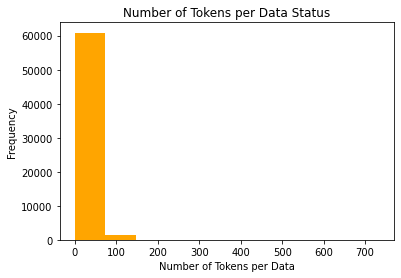

In [6]:
plt.title("Number of Tokens per Data Status")
plt.xlabel("Number of Tokens per Data")
plt.ylabel("Frequency")
plt.hist([len(data) for data in train_dataset], color="orange")
plt.show()

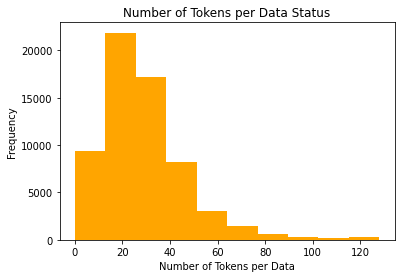

In [7]:
plt.title("Number of Tokens per Data Status")
plt.xlabel("Number of Tokens per Data")
plt.ylabel("Frequency")
plt.hist([min(len(data), 128) for data in train_dataset], color="orange")
plt.show()

In [8]:
print(f"Percent of Long-tail data = {sum([len(data)>64 for data in train_dataset]) * 100 / len(train_dataset)} %")

Percent of Long-tail data = 4.362078063288508 %


# Split Long Data

In [9]:
max_length = 64

In [10]:
def split_long_data(dataset, max_length):
  new_dataset = []
  for data in dataset:
    number_new_data = math.ceil(len(data)/max_length)

    for i in range(number_new_data):
      new_dataset.append(data[i*max_length : min((i+1)*max_length, len(data))])

  return new_dataset

In [11]:
train_dataset = split_long_data(train_dataset, max_length)
test_dataset = split_long_data(test_dataset, max_length)
valid_dataset = split_long_data(valid_dataset, max_length)

# Tag to Index

In [12]:
all_tag = set()

for data in train_dataset:
  for item in data:
    tag = item[1]
    all_tag.add(tag)

In [13]:
tag2index = {tag:i+1 for i, tag in enumerate(all_tag)}
tag2index["PAD"] = 0

# Word to Vec 

In [14]:
file = open("/content/vectors.txt", "r")

word2vector = {}

for i, line in enumerate(file.readlines()):
  line_splitted = line.split()
  word = line_splitted[0]
  vector = np.array(line_splitted[1:], dtype="float")

  word2vector[word] = vector

In [15]:
embedding_size = len(word2vector['#1'])

# Digitalize & Padding

In [16]:
def preprocess(dataset, max_length, embedding_size):
  digitalized_dataset = []
  dataset_X = []
  dataset_y = []

  for data in dataset:
    dataset_X.append([])
    dataset_y.append([])

    for item in data:
      vector = word2vector.get(item[0], np.zeros(embedding_size))
      tag_index = tag2index[item[1]]
      dataset_X[-1].append(vector)
      dataset_y[-1].append(tag_index)

    for _ in range(max_length-len(dataset_y[-1])):
      dataset_y[-1].append(0)
      dataset_X[-1].append(np.zeros(embedding_size))

  dataset_X = np.array(dataset_X)
  dataset_y = np.array(dataset_y)

  return dataset_X, dataset_y

In [17]:
train_X, train_y = preprocess(train_dataset, max_length, embedding_size)
test_X, test_y = preprocess(test_dataset, max_length, embedding_size)
valid_X, valid_y = preprocess(valid_dataset, max_length, embedding_size)

# Accuracy Metric

In [18]:
def ignore_class_accuracy(to_ignore=0):
   # Refrence: https://nlpforhackers.io/lstm-pos-tagger-keras/
  
  def ignore_accuracy(y_true, y_pred):
    y_pred_class = backend.argmax(y_pred, axis=-1)
    y_true_class = backend.argmax(y_true, axis=-1)
    y_true_class = backend.cast(y_true, "int64")

    ignore_mask = backend.cast(backend.not_equal(y_pred_class, to_ignore), 'int32')
    matches = backend.cast(backend.equal(y_true_class, y_pred_class), 'int32') * ignore_mask
    accuracy = backend.sum(matches) / backend.maximum(backend.sum(ignore_mask), 1)
    return accuracy
  
  return ignore_accuracy

# BiLSTM Model

In [27]:
class BiLSTM(keras.Model):
  def __init__(self, max_length, embedding_size, number_tags, lstm_units):
    super().__init__()
    self.model = Sequential([
                             Input((max_length, embedding_size)),
                             Bidirectional(LSTM(lstm_units, return_sequences=True)),
                             TimeDistributed(Dense(number_tags+1, activation="softmax"))
    ])
  
  def call(self, inputs):
    return self.model(inputs)

In [28]:
model = BiLSTM(max_length=max_length, embedding_size=embedding_size, number_tags=len(all_tag), lstm_units=64)

In [29]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy", ignore_class_accuracy(0)])

In [30]:
es_callback = EarlyStopping(monitor="val_loss", restore_best_weights=True, patience=2)

# Training

In [31]:
model.fit(x=train_X, y=train_y, epochs=15, validation_data=(valid_X, valid_y), callbacks=[es_callback])

Epoch 1/15
2054/2054 [==============================] - 198s 93ms/step - loss: 0.3439 - accuracy: 0.9040 - ignore_accuracy: 0.7876 - val_loss: 0.1891 - val_accuracy: 0.9446 - val_ignore_accuracy: 0.8758
Epoch 2/15
2054/2054 [==============================] - 178s 87ms/step - loss: 0.1614 - accuracy: 0.9520 - ignore_accuracy: 0.8918 - val_loss: 0.1394 - val_accuracy: 0.9581 - val_ignore_accuracy: 0.9061
Epoch 3/15
2054/2054 [==============================] - 183s 89ms/step - loss: 0.1301 - accuracy: 0.9611 - ignore_accuracy: 0.9125 - val_loss: 0.1200 - val_accuracy: 0.9641 - val_ignore_accuracy: 0.9196
Epoch 4/15
2054/2054 [==============================] - 176s 86ms/step - loss: 0.1144 - accuracy: 0.9658 - ignore_accuracy: 0.9230 - val_loss: 0.1077 - val_accuracy: 0.9676 - val_ignore_accuracy: 0.9276
Epoch 5/15
2054/2054 [==============================] - 178s 87ms/step - loss: 0.1050 - accuracy: 0.9685 - ignore_accuracy: 0.9291 - val_loss: 0.1001 - val_accuracy: 0.9699 - val_ignore_ac

# Error Plot

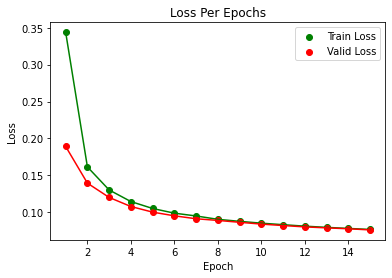

In [32]:
plt.title("Loss Per Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")

train_loss_list = model.history.history["loss"]
valid_loss_list = model.history.history["val_loss"]

epochs = range(1, len(train_loss_list)+1)

plt.scatter(epochs, train_loss_list, label="Train Loss", color="green")
plt.scatter(epochs, valid_loss_list, label="Valid Loss", color="red")

plt.plot(epochs, train_loss_list, color="green")
plt.plot(epochs, valid_loss_list, color="red")

plt.legend()

plt.show()

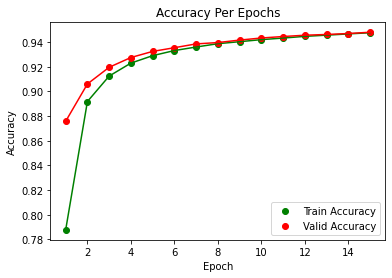

In [33]:
plt.title("Accuracy Per Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

train_accuracy_list = model.history.history["ignore_accuracy"]
valid_accuracy_list = model.history.history["val_ignore_accuracy"]

epochs = range(1, len(train_accuracy_list)+1)

plt.scatter(epochs, train_accuracy_list, label="Train Accuracy", color="green")
plt.scatter(epochs, valid_accuracy_list, label="Valid Accuracy", color="red")

plt.plot(epochs, train_accuracy_list, color="green")
plt.plot(epochs, valid_accuracy_list, color="red")

plt.legend()

plt.show()

# Evalluation

In [34]:
model.evaluate(train_X, train_y)
model.evaluate(valid_X, valid_y)
model.evaluate(test_X, test_y)

441/441 [==============================] - 11s 24ms/step - loss: 0.0768 - accuracy: 0.9766 - ignore_accuracy: 0.9480


[0.07676643878221512, 0.976638913154602, 0.9479774832725525]

In [37]:
test_yp = model.predict(test_X).argmax(-1)

In [38]:
index2tag = {v:k for k, v in tag2index.items()}

In [39]:
precision, recall, fscore, support = precision_recall_fscore_support(test_y.flatten(), test_yp.flatten())

In [49]:
for i in range(len(precision)):
  print(f"Tag = {index2tag[i]} | Recall = {int(recall[i]*100)} | Precision = {int(precision[i]*100)}")

Tag = PAD | Recall = 99 | Precision = 99
Tag = N_PL | Recall = 91 | Precision = 93
Tag = N_VOC | Recall = 53 | Precision = 77
Tag = ADJ_INO | Recall = 42 | Precision = 76
Tag = N_SING | Recall = 95 | Precision = 95
Tag = ADV_COMP | Recall = 75 | Precision = 89
Tag = V_SUB | Recall = 92 | Precision = 92
Tag = DET | Recall = 95 | Precision = 96
Tag = CLITIC | Recall = 99 | Precision = 99
Tag = V_AUX | Recall = 91 | Precision = 98
Tag = P | Recall = 99 | Precision = 98
Tag = ADV_I | Recall = 86 | Precision = 90
Tag = PRO | Recall = 96 | Precision = 96
Tag = ADV_TIME | Recall = 91 | Precision = 92
Tag = V_PRS | Recall = 95 | Precision = 96
Tag = DELM | Recall = 95 | Precision = 88
Tag = FW | Recall = 70 | Precision = 80
Tag = V_PP | Recall = 93 | Precision = 96
Tag = V_IMP | Recall = 35 | Precision = 68
Tag = ADJ | Recall = 89 | Precision = 90
Tag = NUM | Recall = 89 | Precision = 91
Tag = ADV_LOC | Recall = 92 | Precision = 92
Tag = ADV | Recall = 67 | Precision = 81
Tag = V_PA | Recall =

# Confusion Matrix

In [51]:
confusion = confusion_matrix(test_y.flatten(), test_yp.flatten())

In [52]:
confusion = confusion[1: , 1:]

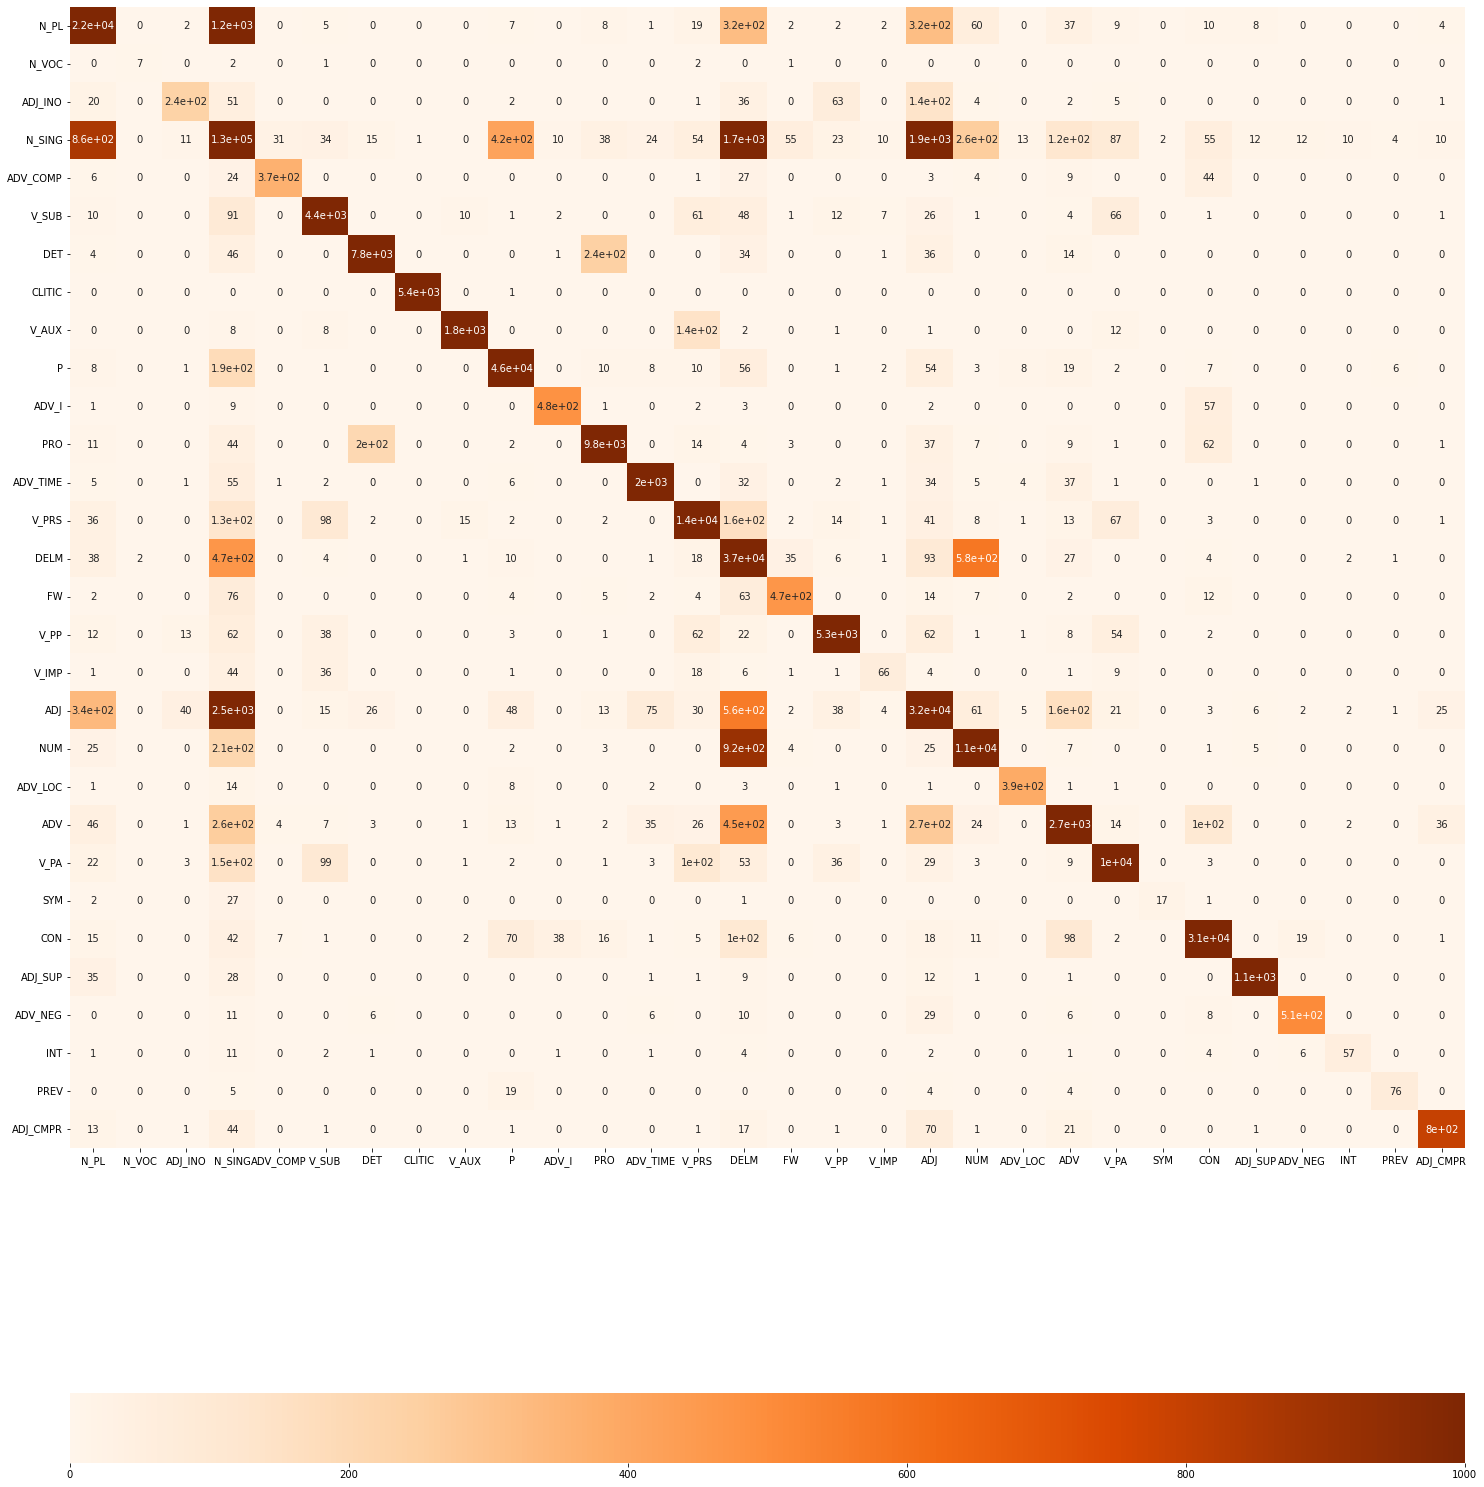

In [53]:
df_cm = pd.DataFrame(confusion, index = [i for i in all_tag],
                     columns = [i for i in all_tag])

plt.figure(figsize = (25,30))
sn.heatmap(df_cm, annot=True, cbar_kws={"orientation": "horizontal"}, vmax=1000, cmap="Oranges")
plt.show()

In [69]:
for irow, row in enumerate(confusion):
  for icol, cell in enumerate(row):
    if irow != icol and cell>1000:
      print(f"Predicted Tag = {index2tag[icol+1]} | True Tag = {index2tag[irow+1]} | Error Number = {cell}")

Predicted Tag = N_SING | True Tag = N_PL | Error Number = 1160
Predicted Tag = DELM | True Tag = N_SING | Error Number = 1673
Predicted Tag = ADJ | True Tag = N_SING | Error Number = 1911
Predicted Tag = N_SING | True Tag = ADJ | Error Number = 2480


In [70]:
true_confusion = confusion_matrix(test_y.flatten(), test_yp.flatten(), normalize="true")
pred_confusion = confusion_matrix(test_y.flatten(), test_yp.flatten(), normalize="pred")

In [71]:
true_confusion = true_confusion[1: , 1:]
pred_confusion = pred_confusion[1: , 1:]

In [72]:
for irow, row in enumerate(confusion):
  for icol, cell in enumerate(row):
    if confusion[irow][icol]>0 and irow != icol:
      if true_confusion[irow][icol] > 0.20: 
        print(f"Predicted Tag = {index2tag[icol+1]} | True Tag = {index2tag[irow+1]} | Error Number = {cell} | True Error = {true_confusion[irow][icol]}")
      if pred_confusion[irow][icol] > 0.20:
        print(f"Predicted Tag = {index2tag[icol+1]} | True Tag = {index2tag[irow+1]} | Error Number = {cell} | Pred Error = {pred_confusion[irow][icol]}")

Predicted Tag = ADJ | True Tag = ADJ_INO | Error Number = 139 | True Error = 0.24865831842576028
Predicted Tag = N_VOC | True Tag = DELM | Error Number = 2 | Pred Error = 0.2222222222222222
Predicted Tag = N_SING | True Tag = V_IMP | Error Number = 44 | True Error = 0.23404255319148937
Predicted Tag = N_SING | True Tag = SYM | Error Number = 27 | True Error = 0.5625
